In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras import mixed_precision
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

BATCH_SIZE = 128

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("/home/nick/dbox/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

/home/nick/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


2pn           2501
Compacting    2430
Blastocyst    2246
Empty         1423
Syngamy       1174
2 Cell        1155
4 Cell        1073
6 Cell         542
8 Cell         537
3 Cell         390
5 Cell         298
9 Cell+        250
Name: class, dtype: int64

<AxesSubplot:>

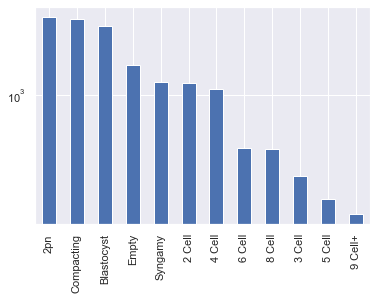

In [2]:
df["class"].value_counts().plot.bar(logy=True)

In [3]:
class_counts = df["class"].value_counts()
#mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [4]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)),500))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), round(len(df_for_class)),2000))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0831_S00493_W1_F0_1950.jpg,2 Cell
1,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0776_S00635_W1_F0_1903.jpg,2 Cell
2,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M0831_S00479_W3_F0_1642.jpg,2 Cell
3,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M3169_S00737_W2_F0_2056.jpg,2 Cell
4,/home/nick/dbox/EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W5_F0_2115.jpg,2 Cell
...,...,...
245,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W3_F0_3943.jpg,9 Cell+
246,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_7311.jpg,9 Cell+
247,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00470_W5_F0_6646.jpg,9 Cell+
248,/home/nick/dbox/EmbryoLabeling/Labelers/train/9 Cell+/M0831_S00479_W1_F0_3782.jpg,9 Cell+


2pn           2000
Compacting    1944
Blastocyst    1797
Empty         1138
Syngamy        939
2 Cell         924
4 Cell         858
6 Cell         434
8 Cell         430
3 Cell         312
5 Cell         238
9 Cell+        200
Name: class, dtype: int64

2pn           500
Compacting    486
Blastocyst    449
Empty         285
Syngamy       235
2 Cell        231
4 Cell        215
6 Cell        108
8 Cell        107
3 Cell         78
5 Cell         60
9 Cell+        50
Name: class, dtype: int64

In [5]:

datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
)


training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 11214 validated image filenames belonging to 12 classes.
Found 2804 validated image filenames belonging to 12 classes.


In [6]:
assert training.class_indices == validation.class_indices

In [7]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 '9 Cell+',
 'Blastocyst',
 'Compacting',
 'Empty',
 'Syngamy']

In [8]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: '9 Cell+',
 8: 'Blastocyst',
 9: 'Compacting',
 10: 'Empty',
 11: 'Syngamy'}

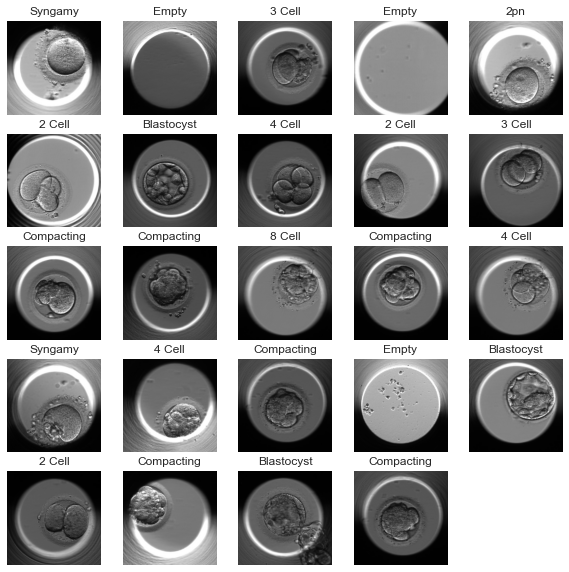

In [9]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

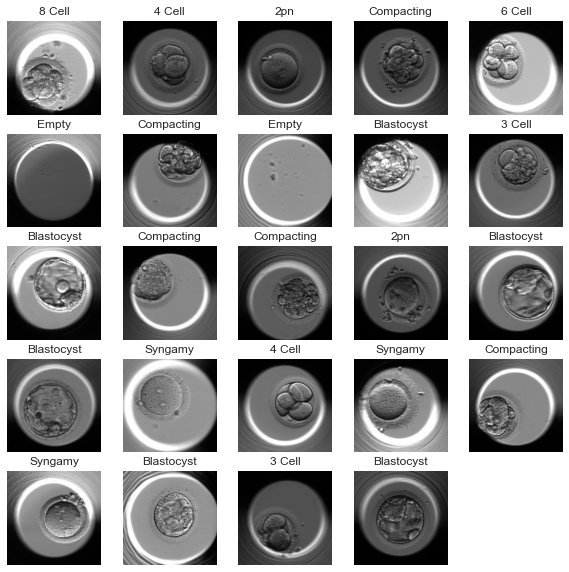

In [11]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i]/255)
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [20]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_enetb5 = keras.applications.EfficientNetB5(
    weights='imagenet',
    input_shape=(456,456,3),
    include_top=False
)
# Freeze the base_model
base_model.trainable = False
base_enetb5.trainable = False

# Create new model on top
inputs = keras.Input(shape=(456, 456, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1./127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_enetb5(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation='relu')(x)
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

115263384/115263384 [==============================] - 2s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 456, 456, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 456, 456, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0  

In [21]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[keras.metrics.CategoricalAccuracy()],
)


CPU times: user 14 ms, sys: 3.4 ms, total: 17.4 ms
Wall time: 16.3 ms


In [22]:

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor='loss',patience=5, verbose=0),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/88           ETA: ?s - 

Epoch 2/500


0/88           ETA: ?s - 

Epoch 3/500


0/88           ETA: ?s - 

Epoch 4/500


0/88           ETA: ?s - 

Epoch 5/500


0/88           ETA: ?s - 

Epoch 6/500


0/88           ETA: ?s - 

Epoch 7/500


0/88           ETA: ?s - 

Epoch 8/500


0/88           ETA: ?s - 

Epoch 9/500


0/88           ETA: ?s - 

Epoch 10/500


0/88           ETA: ?s - 

Epoch 11/500


0/88           ETA: ?s - 

Epoch 12/500


0/88           ETA: ?s - 

Epoch 13/500


0/88           ETA: ?s - 

Epoch 14/500


0/88           ETA: ?s - 

Epoch 15/500


0/88           ETA: ?s - 

Epoch 16/500


0/88           ETA: ?s - 

KeyboardInterrupt: 

<AxesSubplot:>

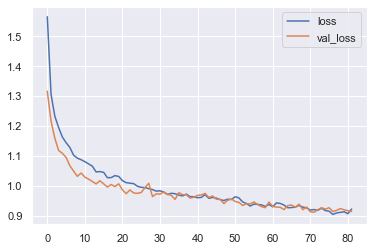

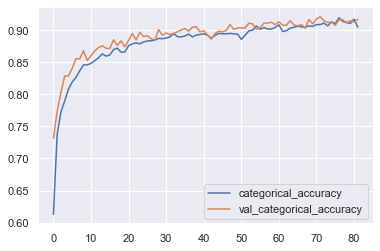

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [14]:
y_pred = model.predict(validation)

22/22 [==============================] - 10s 420ms/step


In [15]:
predicted_codes = y_pred.argmax(axis=1)
confidence = pd.Series(y_pred.max(axis=1))
confidence.describe()

count    2804.000000
mean        0.763251
std         0.147725
min         0.187811
25%         0.638809
50%         0.836271
75%         0.869759
max         0.959394
dtype: float64

In [16]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
1025,/home/nick/dbox/EmbryoLabeling/Labelers/train/Empty/M3169_S00668_W15_F0_8140.jpg,Empty,Empty,0.885745
8,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00512_W4_F0_6251.jpg,Blastocyst,Blastocyst,0.900365
1710,/home/nick/dbox/EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00512_W8_F0_6442.jpg,Blastocyst,Blastocyst,0.863550
103,/home/nick/dbox/EmbryoLabeling/Labelers/train/Syngamy/M3169_S00737_W1_F0_1740.jpg,Syngamy,Syngamy,0.817585
66,/home/nick/dbox/EmbryoLabeling/Labelers/train/8 Cell/M0776_S00512_W1_F0_3892.jpg,8 Cell,8 Cell,0.856557
...,...,...,...,...
916,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M776_S0087_W2_F0_4306.jpg,Compacting,Compacting,0.584258
1544,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M0776_S00512_W3_F0_5490.jpg,Compacting,Compacting,0.877147
338,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00512_W4_F0_1869.jpg,3 Cell,4 Cell,0.564398
98,/home/nick/dbox/EmbryoLabeling/Labelers/train/Compacting/M0776_S00761_W3_F0_4410.jpg,Compacting,8 Cell,0.882436


In [17]:
validation_df.groupby("class").confidence.median()

class
2 Cell        0.850284
2pn           0.825252
3 Cell        0.837057
4 Cell        0.835196
5 Cell        0.830557
6 Cell        0.842046
8 Cell        0.830134
9 Cell+       0.810742
Blastocyst    0.843823
Compacting    0.838832
Empty         0.835423
Syngamy       0.844058
Name: confidence, dtype: float32

              precision    recall  f1-score   support

      2 Cell       0.92      0.96      0.94       231
         2pn       0.87      0.97      0.92       500
      3 Cell       0.78      0.73      0.75        78
      4 Cell       0.86      0.91      0.88       215
      5 Cell       0.83      0.50      0.62        60
      6 Cell       0.77      0.77      0.77       108
      8 Cell       0.83      0.84      0.83       107
     9 Cell+       0.94      0.94      0.94        50
  Blastocyst       0.99      0.96      0.97       449
  Compacting       0.93      0.97      0.95       486
       Empty       1.00      1.00      1.00       285
     Syngamy       0.91      0.70      0.79       235

    accuracy                           0.91      2804
   macro avg       0.89      0.85      0.86      2804
weighted avg       0.91      0.91      0.91      2804



Text(30.453125, 0.5, 'True')

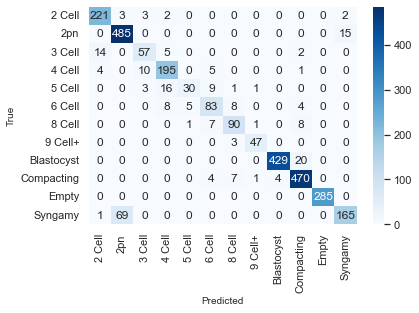

In [18]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [19]:
model.save(f"models/dense_{len(code2class)}_class.h5")